# Pet Image Classification and Detection with Transformers

- [View Solution Notebook](./solutions.html)
- [View Project Page](https://www.codecademy.com/content-items/b69d23099ee44d2aa72353c75f3f780)

**Setup - Libraries and Custom PCam Dataset Loading Class**

Run the cell below to import the libraries and the custom `oxford_pet` classes and functions.

In [1]:
from torchvision.datasets import OxfordIIITPet
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTImageProcessor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import oxford_pet
%matplotlib inline
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

def collate_fn(batch):
    images, labels, targets = zip(*batch)
    return list(images), list(labels), list(targets)
    

/opt/anaconda3/envs/TRtest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Task Group 1 - Image Classification with ViT

Let's first train a ViT to identify cats vs. dogs in the dataset!

### Task 1
Load the pretrained Vision Transformer (ViT) model and update it for binary classification (cat vs dog).
* Use "google/vit-base-patch16-224" and set `num_labels=2`, providing both label2id and id2label dictionaries.  In this case, index "0" represents "cat" and "1" represents "dog."
* Enable `ignore_mismatched_sizes=True` to allow the classifier head to be overwritten.

In [2]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    id2label={0: "cat", 1: "dog"},
    label2id={"cat": 0, "dog": 1},
    ignore_mismatched_sizes=True
)

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
processor

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Task 2
* Create a transformation pipeline that resizes images to 224×224, converts them to tensors, and normalizes them using the pre-trained processor's mean and standard deviation values.
* Store this transformation in the variable `transform.`

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

### Task 3
* Create `train,` `validation,` and `test` datasets using the custom `OxfordPetDetectionDataset` class.
* Use the transform pipeline and set `max_size=100` to limit the dataset size for faster experimentation.
* Assign them to the variables `train_dataset,` `val_dataset,` and `test_dataset.`
* Wrap the datasets into `DataLoaders` with batching and shuffling enabled for training, and store the loaders in `train_loader,` `val_loader,` and `test_loader.`

In [4]:
train_dataset = oxford_pet.OxfordPetDetectionDataset("./", split="train", transforms=transform, max_size=100)
val_dataset   = oxford_pet.OxfordPetDetectionDataset("./", split="val", transforms=transform, max_size=100)
test_dataset  = oxford_pet.OxfordPetDetectionDataset("./", split="test", transforms=transform, max_size=100)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

### Task 4
* Extract the image, label, and target for a sample using `train_dataset[0]` or any other valid index.
* Visualize example images with bounding boxes using the `plot_image_with_boxes` function from `oxford_pet,` and passing in the image and target.  
* Display at least two examples from the training set using their index.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


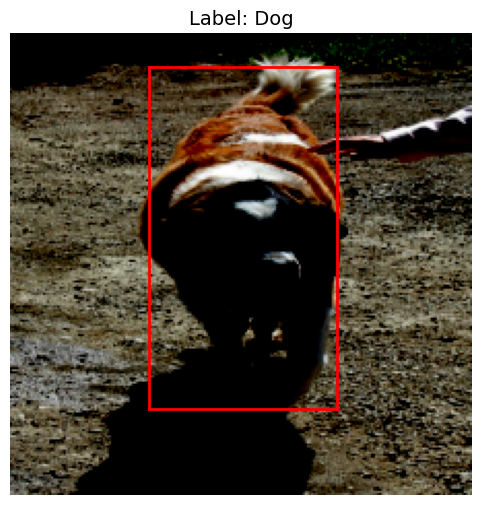

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


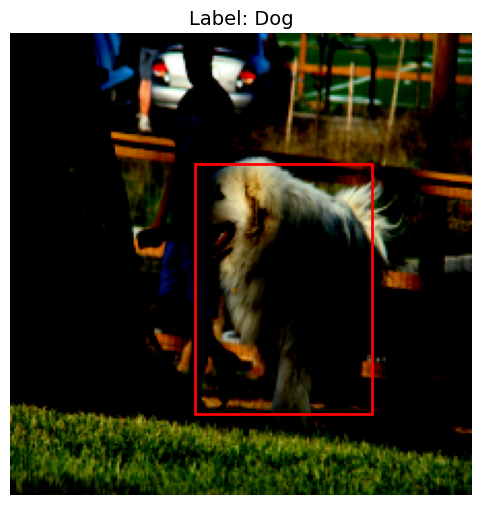

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.60784316].


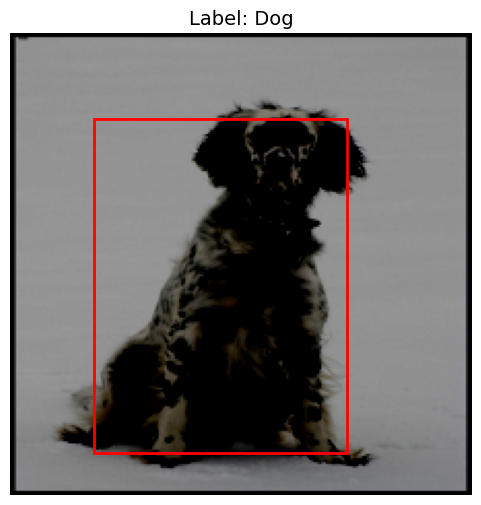

In [5]:
for i in [0, 1, 2]: # or whatever indices I choose
    image, label, target = train_dataset[i] # extraction step for index i
    oxford_pet.plot_image_with_boxes(image, target) # plotting step for extracted data

### Task 5
* Freeze all layers in the ViT model except for the final classification head, and define your optimizer and loss function.
* Use the Adam optimizer with a learning rate 0.001 and CrossEntropyLoss as your criterion.

In [6]:
model.named_parameters()
print(model)

# Step 1: Freeze parameters
for name, param in model.named_parameters():
    if not name.startswith("classifier"):
        param.requires_grad = False

# Step 2: Create optimizer
# Use model.parameters() directly (since the unwanted layers are already frozen)
optimizer = torch.optim.Adam(model.named_parameters(), lr=0.001)

# Step 3: Create loss function
criterion = torch.nn.CrossEntropyLoss()

device = torch.device("mps" if torch.mps.is_available() else "cpu")

model.to(device)

device

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

device(type='mps')

### Task 6
* Train the ViT model for three epochs using the training DataLoader.
* Print the average loss and accuracy after each epoch.

In [7]:
device = next(model.parameters()).device
print(f"Model is on: {device}")

Model is on: mps:0


In [8]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    # Your batch loop goes here

    for images, labels, targets in train_loader:

        # Move data to the same device as model
        images = images.to(device)
        labels = labels.to(device)
        
        # Now you have images and labels for classification
        outputs = model(images)
        logits = outputs.logits
        loss = criterion(logits, labels)

        # Accumulate loss
        total_loss += loss.item()
        
        # Calculate accuracy
        predictions = torch.argmax(logits, dim=1)  # Get predicted class
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update weights
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

Epoch 1: Loss = 0.3965, Accuracy = 0.8947
Epoch 2: Loss = 0.0846, Accuracy = 1.0000
Epoch 3: Loss = 0.0294, Accuracy = 1.0000


### Task 7
* Evaluate the ViT model on the test set and calculate its accuracy.
* Print the final accuracy and generate a confusion matrix and classification report using `sklearn.`

Using device: mps
Evaluating model on test set...

FINAL TEST ACCURACY: 1.0000 (100.00%)


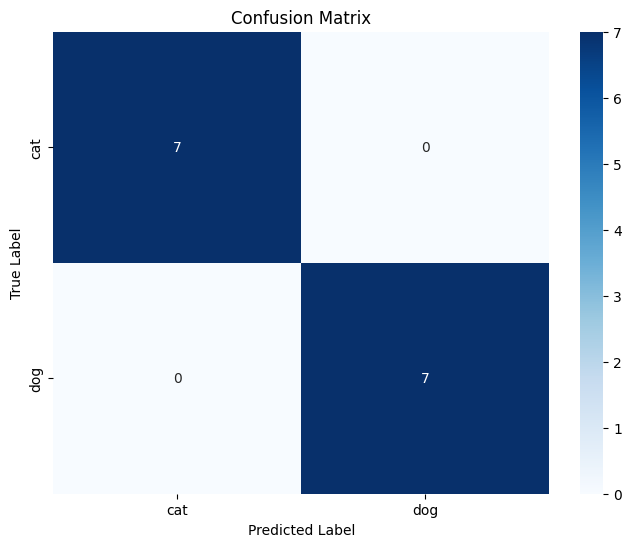


Confusion Matrix:
[[7 0]
 [0 7]]

Classification Report:
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00         7
         dog       1.00      1.00      1.00         7

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14


Detailed Results:
Total test samples: 14
Correct predictions: 14
Incorrect predictions: 0
Cat accuracy: 1.0000 (100.00%)
Dog accuracy: 1.0000 (100.00%)


In [9]:
import torch.nn.functional as F

def evaluate_vit_model(model, test_loader, device):
    """
    Evaluate ViT model on test set and generate metrics
    """
    model.eval()
    model.to(device)
    
    all_predictions = []
    all_labels = []
    
    print("Evaluating model on test set...")
    
    with torch.no_grad():
        for batch_idx, (images, labels, targets) in enumerate(test_loader):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get predictions
            _, predicted = torch.max(outputs.logits, 1)
            
            # Store predictions and labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Print progress
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")
    
    return np.array(all_predictions), np.array(all_labels)

def generate_metrics(predictions, labels, class_names=None):
    """
    Generate accuracy, confusion matrix, and classification report
    """
    if class_names is None:
        class_names = ['cat', 'dog']
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    print(f"\n{'='*50}")
    print(f"FINAL TEST ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"{'='*50}")
    
    # Generate confusion matrix
    cm = confusion_matrix(labels, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print confusion matrix
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Generate and print classification report
    print(f"\nClassification Report:")
    print(classification_report(labels, predictions, target_names=class_names))
    
    return accuracy, cm

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Evaluate the model
predictions, labels = evaluate_vit_model(model, test_loader, device)

# Generate metrics
accuracy, confusion_matrix = generate_metrics(predictions, labels, class_names=['cat', 'dog'])

# Additional detailed metrics
print(f"\nDetailed Results:")
print(f"Total test samples: {len(labels)}")
print(f"Correct predictions: {np.sum(predictions == labels)}")
print(f"Incorrect predictions: {np.sum(predictions != labels)}")

# Per-class accuracy
for i, class_name in enumerate(['cat', 'dog']):
    class_mask = labels == i
    class_accuracy = accuracy_score(labels[class_mask], predictions[class_mask])
    print(f"{class_name.capitalize()} accuracy: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

## Task Group 2 - Object Detection with DETR

Now, let's use the bounding box annotations to locate pets in the images and evaluate how well a pretrained object detection model (e.g., DETR) performs on this task!

In [10]:
#clean up delete previous model
import gc
# Clean up model if it exists
if 'model' in locals():
    del model

# Clean up inputs if you're not sure they're defined
if 'inputs' in locals():
    del inputs

# Clear cache and run garbage collection
gc.collect()
torch.mps.empty_cache()


### Task 8
* Load the pre trained DETR model (`facebook/detr-resnet-50`) for object detection using Hugging Face’s `DetrImageProcessor` and `DetrForObjectDetection.` Use `revision="no_timm"` and set `do_rescale=False.`
* Load the processor using the model name and parameters `size={"shortest_edge": 800, "longest_edge": 1333},do_resize=True, do_rescale=True, do_normalize=True` to match the model's preprocessing.
* Use `device = torch.device("cpu")` and set the model to evaluate and move to the device.

In [11]:
# from transformers import [ProcessorClass], [ModelClass]
from transformers import DetrImageProcessor, DetrForObjectDetection

detr = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    
    revision="no_timm",
    # specifies which version or variant of the model
    # to load from the Hugging Face Hub
    # Uses PyTorch's native ResNet implementation instead of the timm library
    # Was created for compatibility reasons (some environments might not have timm installed)
    
    # do_rescale=False
    # Claude said: "The task instructions might have been unclear about
    # where to place do_rescale=False,
    # but it doesn't belong in the model loading.
)

detr_proc = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50",
    size={
        "shortest_edge": 800,
        "longest_edge": 1333
    },
    do_resize=True,
    do_rescale=True,
    do_normalize=True
)

device = torch.device("mps")
detr.eval()
detr.to(device)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

### Task 9
* Use `OxfordPetDetectionDataset` with `split="val"` and `max_size=10` and `transforms=None.`
* Create a DataLoader for DETR evaluation using the `collate_fn` to avoid automatic batching of target dictionaries.
* Store it in the variable `detection_loader.`

In [12]:
detection_dataset = oxford_pet.OxfordPetDetectionDataset(
    "./",
    split="val",
    transforms=None,
    max_size=100
)
detection_loader = DataLoader(
    detection_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn

    # By default, PyTorch's DataLoader tries to automatically
    # combine (batch) individual samples into tensors.

    # Object detection datasets return target dictionaries that
    # have different numbers of boxes and labels
    # so PyTorch's default batching can't stack these into a single tensor.

    # Instead of trying to stack the targets into one tensor,
    # collate_fn keeps them as a list of dictionaries.
)

### Task 10
* Evaluate the DETR model on the validation set using `evaluate_detr` function from `oxford_pet.`
* Pass as parameters to the function `detr_model, processor, detection_loader, device, score_threshold=0.7.`
* Display average IoU and detection accuracy using an IoU threshold of 0.7.

In [13]:
oxford_pet.evaluate_detr(
    model=detr,
    processor=detr_proc,
    dataloader=detection_loader,
    device=device,
    score_threshold=0.7,
    iou_threshold=0.7
)


📊 Evaluation Results (score_threshold=0.7):
Average IoU: 0.829
Detection Accuracy (IoU > 0.7): 2/2 (100.0%)
Precision: 0.667
Recall:    1.000
F1 Score:  0.800


### Task 11
* Repeat the evaluation with different score thresholds, such as 0.5 or 0.9.

In [14]:
oxford_pet.evaluate_detr(
    model=detr,
    processor=detr_proc,
    dataloader=detection_loader,
    device=device,
    score_threshold=0.99,
    iou_threshold=0.7
)


📊 Evaluation Results (score_threshold=0.99):
Average IoU: 0.829
Detection Accuracy (IoU > 0.7): 2/2 (100.0%)
Precision: 1.000
Recall:    1.000
F1 Score:  1.000


In [15]:
oxford_pet.evaluate_detr(
    model=detr,
    processor=detr_proc,
    dataloader=detection_loader,
    device=device,
    score_threshold=0.01,
    iou_threshold=0.7
)


📊 Evaluation Results (score_threshold=0.01):
Average IoU: 0.833
Detection Accuracy (IoU > 0.7): 2/2 (100.0%)
Precision: 0.049
Recall:    1.000
F1 Score:  0.093


### Task 12
* Visualize predictions from the DETR model alongside the ground truth bounding box using `plot_detr_prediction` from `oxford_pet.`
* Extract the image and target from the dataset using `img, _, target = detection_val[0]` or another index.
* Pass `img, detr_model, processor, target=target` as inputs to the function `plot_detr_prediction.`
* Run this on a few examples from the validation set to inspect detection quality using a high `score_threshold=0.98.` 

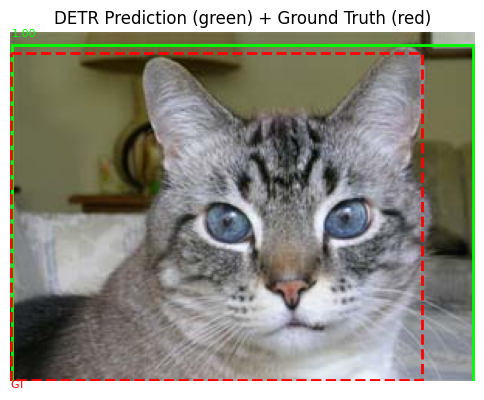

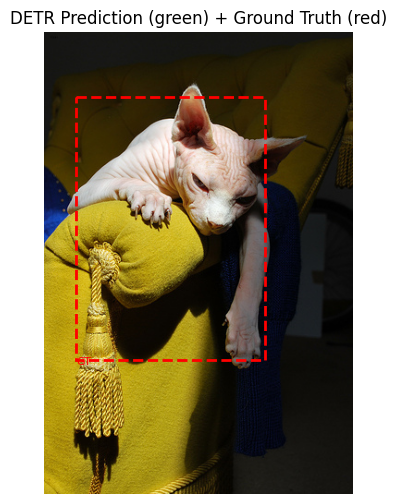

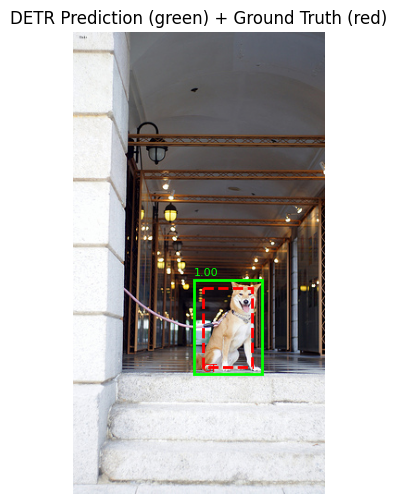

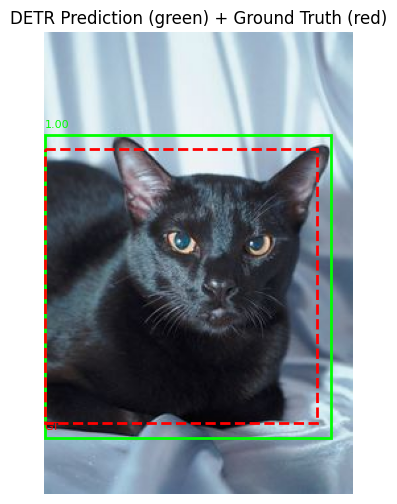

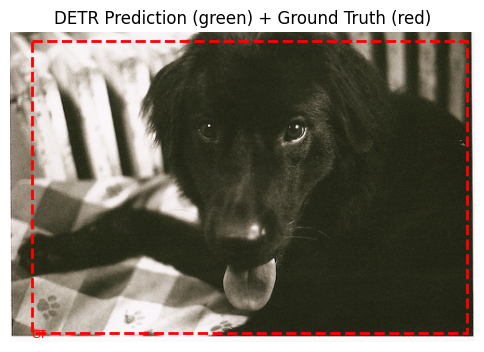

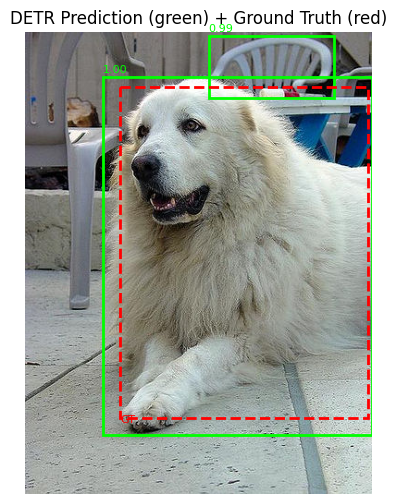

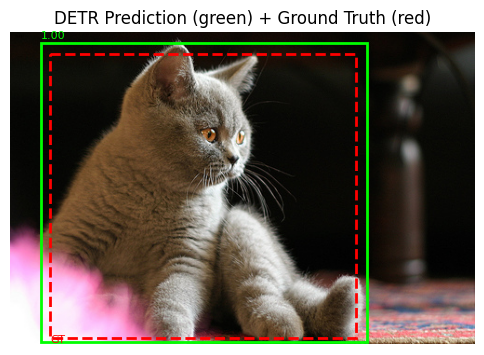

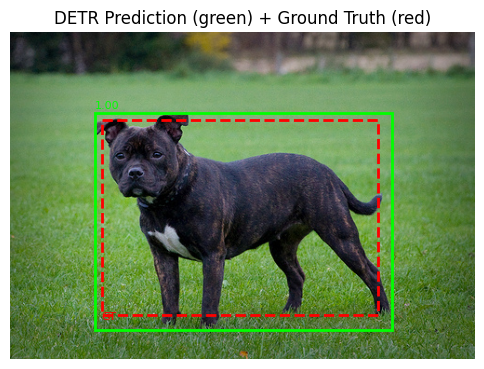

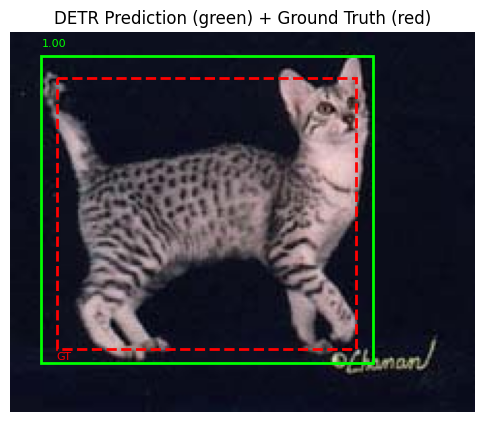

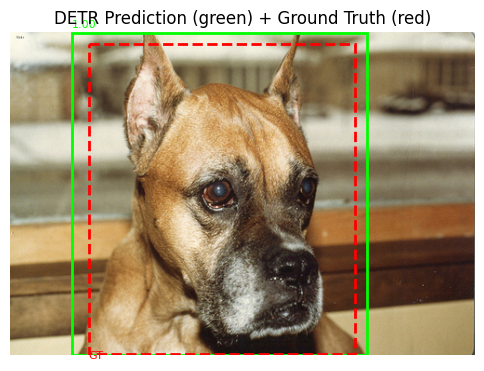

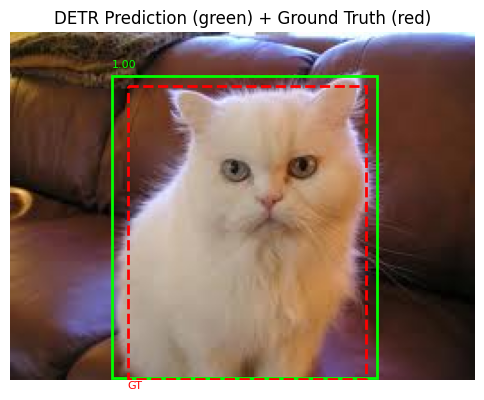

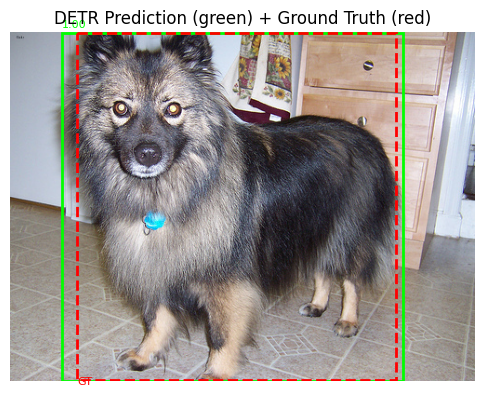

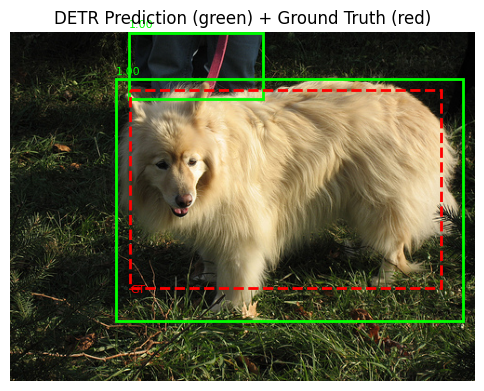

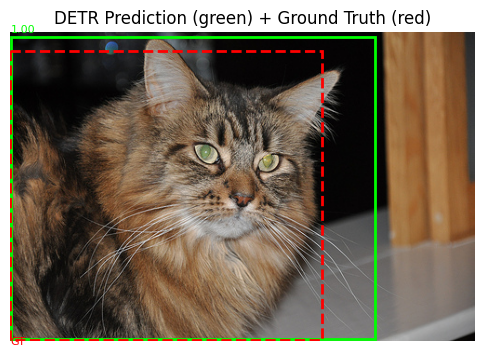

In [16]:
# import random

# for i in random.sample(range(len(detection_dataset)), 3):
for i in range(len(detection_dataset)):
    
    img, _, target = detection_dataset[i]
    
    # # Move target tensors to CPU
    # target_cpu = {}
    # for key, value in target.items():
    #     if isinstance(value, torch.Tensor):
    #         target_cpu[key] = value.cpu()
    #     else:
    #         target_cpu[key] = value
    
    # Convert target to CPU
    target_cpu = {k: v.cpu() if torch.is_tensor(v) else v for k, v in target.items()}
    
    oxford_pet.plot_detr_prediction(
        image=img,
        model=detr.cpu(),
        processor=detr_proc,
        device=torch.device("cpu"),
        target=target_cpu,
        score_threshold=0.98
    )

Nice work! You’ve just wrapped up a full project on classifying and detecting pets using deep learning models on the Oxford-IIIT Pet dataset. You built a Vision Transformer (ViT) for binary classification and evaluated a pretrained DETR model for object detection — a fantastic combination of modern vision tools.

There's definitely room for further exploration, and we encourage you to use your skills to expand on what you’ve learned here!

Here are a few ideas to take your project even further:

- Try out data augmentation techniques like random cropping, color jitter, or horizontal flipping to improve model generalization.
- Experiment with different model architectures or pretrained checkpoints (e.g., smaller ViTs like DeiT or CNN baselines like ResNet).
- Fine-tune the DETR model on your dataset for more confident predictions, especially with lower-confidence samples.
- Add validation loss tracking to monitor for overfitting when fine-tuning.

While this project focused on pets, these methods are broadly applicable to many real-world computer vision tasks — from wildlife conservation to self-driving cars to healthcare.

We hope this project gave you a solid foundation in applying transformers to image classification and object detection — and some inspiration for your next experiments.

🐶🐱 Happy coding!

In [17]:
len(detection_dataset)

14